In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
plt.rcParams.update({'font.size': 18})

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/batlow/batlow.txt")[::-1]
batlow_map = LinearSegmentedColormap.from_list("Batlow", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/cork/cork.txt")
cork_map = LinearSegmentedColormap.from_list("Cork", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/berlin/berlin.txt")
berlin_map = LinearSegmentedColormap.from_list("Berlin", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/lapaz/lapaz.txt")
lapaz_map = LinearSegmentedColormap.from_list("LaPaz", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/tokyo/tokyo.txt")
tokyo_map = LinearSegmentedColormap.from_list("Tokyo", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/bamako/bamako.txt")
bamako_map = LinearSegmentedColormap.from_list("Bamako", cm_data)

cm_data = np.loadtxt("/Users/davidlafferty/Projects/misc/ScientificColourMaps5/turku/turku.txt")[::-1]
turku_map = LinearSegmentedColormap.from_list("Turku", cm_data)

In [2]:
# Import plotting shapefiles
county_shp = gp.read_file('../../data/conus_shp/conus_plot/final/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)
county_shp['area'] = county_shp['geometry'].apply(lambda x: x.area)
county_shp = county_shp.query('area > 10e3')

states = gp.read_file('../../data/conus_shp/conus_plot/final/states_contig_plot.shp')
coast = gp.read_file('../../data/conus_shp/conus_plot/final/coast_contig_plot.shp')

In [3]:
# Add State filter for plot
StateDrop = ['53', '41', '16', '06', '04', '49', '56', '30', '08', '35'] # 10 westernmost CONUS states
StateKeep = states['STATEFP'].unique()
locs = [np.where(StateKeep == drop) for drop in StateDrop]
StateKeep = np.delete(StateKeep, locs)

In [4]:
# Filter
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['GEOID'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
county_shp_plot = county_shp_plot.loc[StateKeep]

In [5]:
# Get results
yield_res = pd.read_csv('../../data/GMFD_all/fitting/gmfd_regression_res_60-05.csv')
yield_res["GEOID"] = yield_res["GEOID"].astype(str).str.zfill(5)
yield_res['state'] = yield_res['GEOID'].apply(lambda x: x[:2])
yield_res.set_index(['GEOID'], inplace = True)

In [6]:
p05_counties = yield_res.query('pval < 0.05').index.unique()

In [7]:
p05_counties

Index(['01001', '01005', '01009', '01011', '01013', '01015', '01017', '01019',
       '01021', '01023',
       ...
       '55121', '55123', '55127', '55129', '55131', '55133', '55135', '55137',
       '55139', '55141'],
      dtype='object', name='GEOID', length=1714)

In [8]:
# Read in data
nex = pd.read_csv('../combine/output/nex_yield_06-16.csv')
nex['GEOID'] = nex["GEOID"].astype(str).str.zfill(5)
nex.set_index(['GEOID', 'Year'],inplace=True)
nex = nex.loc[p05_counties]

cmip = pd.read_csv('../combine/output/cmip_yield_06-16.csv')
cmip['GEOID'] = cmip["GEOID"].astype(str).str.zfill(5)
cmip.set_index(['GEOID', 'Year'],inplace=True)
cmip = cmip.loc[p05_counties]

In [9]:
# Fiter minimum of 5 years
nex['count'] = 1.
nex_count = nex.sum(level = 'GEOID')
nex_count = nex_count.query('count >= 5').index.unique(level = 'GEOID')

nex = nex.loc[nex_count]
cmip = cmip.loc[nex_count]

del nex['count']

In [10]:
# Example
querystring = 'GEOID == "' + '17019' + '"'
# Ensembles
NEXens = nex.query(querystring).drop(columns = ['GMFD', 'USDA', 'ensemble_mean']).to_numpy().flatten()
CMIPens = cmip.query(querystring).drop(columns = ['GMFD', 'USDA', 'ensemble_mean']).to_numpy().flatten()
# Obs
GMFDobs = nex.query(querystring).filter(['GMFD']).to_numpy().flatten()
USDAobs = nex.query(querystring).filter(['USDA']).to_numpy().flatten()

In [11]:
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [12]:
%%time
# Construct CDFs
nexgrid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.5*silverman(NEXens), 3*silverman(NEXens), 30)})
cmipgrid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.5*silverman(CMIPens), 3*silverman(CMIPens), 30)})

nexgrid.fit(NEXens[:, None]);
cmipgrid.fit(CMIPens[:, None]);

NEX_ens_pdf = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth']);
NEX_ens_pdf.fit(NEXens[:, np.newaxis]);

CMIP_ens_pdf = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth']);
CMIP_ens_pdf.fit(CMIPens[:, np.newaxis]);

CPU times: user 397 ms, sys: 15.8 ms, total: 413 ms
Wall time: 422 ms


KernelDensity(algorithm='auto', atol=0, bandwidth=0.07497875349912672,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

In [13]:
print(nexgrid.best_params_)
print(cmipgrid.best_params_)

{'bandwidth': 0.05154820294307216}
{'bandwidth': 0.07497875349912672}


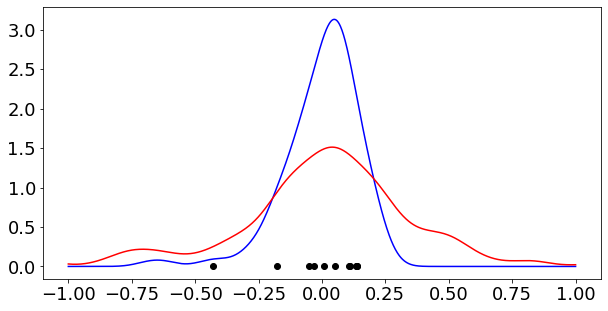

In [14]:
# Example plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
xarr = np.linspace(-1,1,1000)
plt.plot(xarr, np.exp(NEX_ens_pdf.score_samples(xarr[:,None])), 'b-')
plt.plot(xarr, np.exp(CMIP_ens_pdf.score_samples(xarr[:,None])), 'r-')
plt.plot(GMFDobs, np.zeros(len(GMFDobs)), 'o', color = 'black')
plt.show()

In [16]:
%%time
NEXres = []
CMIPres = []
for geoid in nex.index.unique(level = 'GEOID'):
    querystring = 'GEOID == "' + str(geoid) + '"'
    # Ensembles
    NEXens = nex.query(querystring).drop(columns = ['GMFD', 'USDA', 'ensemble_mean']).to_numpy().flatten()
    CMIPens = cmip.query(querystring).drop(columns = ['GMFD', 'USDA', 'ensemble_mean']).to_numpy().flatten()
    # Obs
    GMFDobs = nex.query(querystring).filter(['GMFD']).to_numpy().flatten()
    USDAobs = nex.query(querystring).filter(['USDA']).to_numpy().flatten()
    # Construct CDFs
    nexgrid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.5*silverman(NEXens), 3*silverman(NEXens), 30)})
    cmipgrid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.5*silverman(CMIPens), 3*silverman(CMIPens), 30)})

    nexgrid.fit(NEXens[:, None]);
    cmipgrid.fit(CMIPens[:, None]);

    NEX_ens_pdf = KernelDensity(bandwidth=nexgrid.best_params_['bandwidth']);
    NEX_ens_pdf.fit(NEXens[:, np.newaxis]);

    CMIP_ens_pdf = KernelDensity(bandwidth=cmipgrid.best_params_['bandwidth']);
    CMIP_ens_pdf.fit(CMIPens[:, np.newaxis]);
    
    NEX_gmfd_likes = NEX_ens_pdf.score_samples(np.sort(GMFDobs)[:,None])
    NEX_usda_likes = NEX_ens_pdf.score_samples(np.sort(USDAobs)[:,None])
    CMIP_gmfd_likes = CMIP_ens_pdf.score_samples(np.sort(GMFDobs)[:,None])
    CMIP_usda_likes = CMIP_ens_pdf.score_samples(np.sort(USDAobs)[:,None])
    
    NEXres.append({'GEOID' : geoid, 'nex_gmfd' : NEX_gmfd_likes, 'nex_usda' : NEX_usda_likes})
    CMIPres.append({'GEOID' : geoid, 'cmip_gmfd' : CMIP_gmfd_likes, 'cmip_usda' : CMIP_usda_likes})

CPU times: user 12min 8s, sys: 7.09 s, total: 12min 15s
Wall time: 12min 36s


In [17]:
# df
NEX_res = pd.DataFrame.from_dict(NEXres)
CMIP_res = pd.DataFrame.from_dict(CMIPres)

In [18]:
# Extract useful values
NEX_res['nex_gmfd_min'] = NEX_res['nex_gmfd'].apply(lambda x: x[0])
NEX_res['nex_gmfd_sum'] = NEX_res['nex_gmfd'].apply(lambda x: np.sum(x))

CMIP_res['cmip_gmfd_min'] = CMIP_res['cmip_gmfd'].apply(lambda x: x[0])
CMIP_res['cmip_gmfd_sum'] = CMIP_res['cmip_gmfd'].apply(lambda x: np.sum(x))

In [19]:
NEX_res.query('GEOID == "17019"')

,GEOID,nex_gmfd,nex_usda,nex_gmfd_min,nex_gmfd_sum
276,17019,"[-2.3782147748448796, -0.003439614150519077, 0...","[-3.0212600576703394, 0.6839802391266403, 0.72...",-2.378215,5.806184


In [20]:
CMIP_res.query('GEOID == "17019"')

,GEOID,cmip_gmfd,cmip_usda,cmip_gmfd_min,cmip_gmfd_sum
276,17019,"[-1.3926623629118051, -0.06509564442305305, 0....","[-1.7395548564686032, 0.2629785524928341, 0.27...",-1.392662,1.58197


In [21]:
# Ratios
ratio = pd.merge(NEX_res, CMIP_res, on = ['GEOID'], suffixes=['_nex', '_cmip'])

ratio['gmfd_min'] = ratio['nex_gmfd_min'] - ratio['cmip_gmfd_min']
# ratio['usda_min'] = ratio['nex_usda_min'] - ratio['cmip_usda_min']

ratio['gmfd_sum'] = ratio['nex_gmfd_sum'] - ratio['cmip_gmfd_sum']
# ratio['usda_sum'] = ratio['nex_usda_sum'] - ratio['cmip_usda_sum']

In [22]:
ratio.query('GEOID == "17019"')

,GEOID,nex_gmfd,nex_usda,nex_gmfd_min,nex_gmfd_sum,cmip_gmfd,cmip_usda,cmip_gmfd_min,cmip_gmfd_sum,gmfd_min,gmfd_sum
276,17019,"[-2.3782147748448796, -0.003439614150519077, 0...","[-3.0212600576703394, 0.6839802391266403, 0.72...",-2.378215,5.806184,"[-1.3926623629118051, -0.06509564442305305, 0....","[-1.7395548564686032, 0.2629785524928341, 0.27...",-1.392662,1.58197,-0.985552,4.224214


In [184]:
# Save
ratio.to_csv('./output/log_likelihoods_oos.csv', index=False)

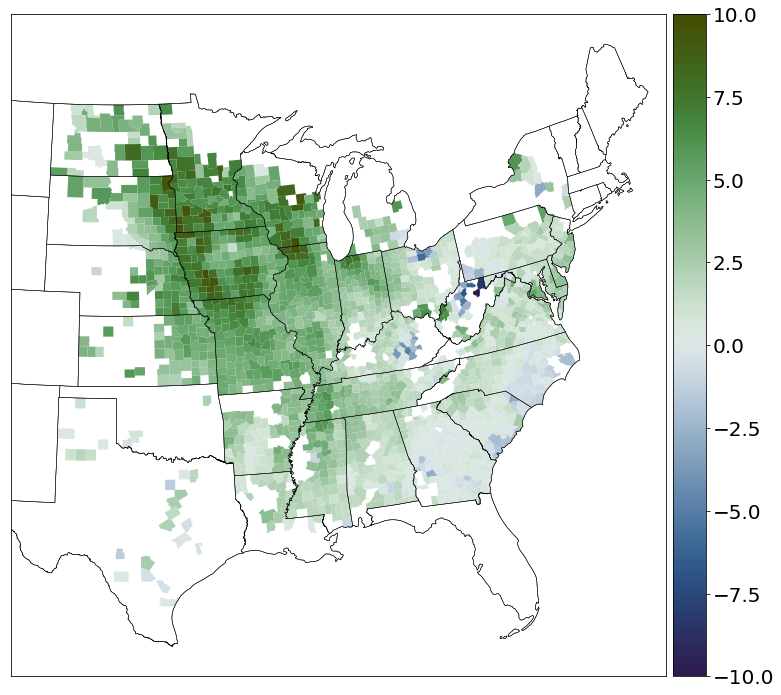

In [169]:
# Plot
model = 'gmfd_sum'
vmin = -10.
vmax = 10.

data = ratio.copy()
data.set_index('GEOID', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.tick_params(labelsize=20)
data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=cork_map, vmin=vmin, vmax=vmax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
plt.tight_layout()
plt.show()

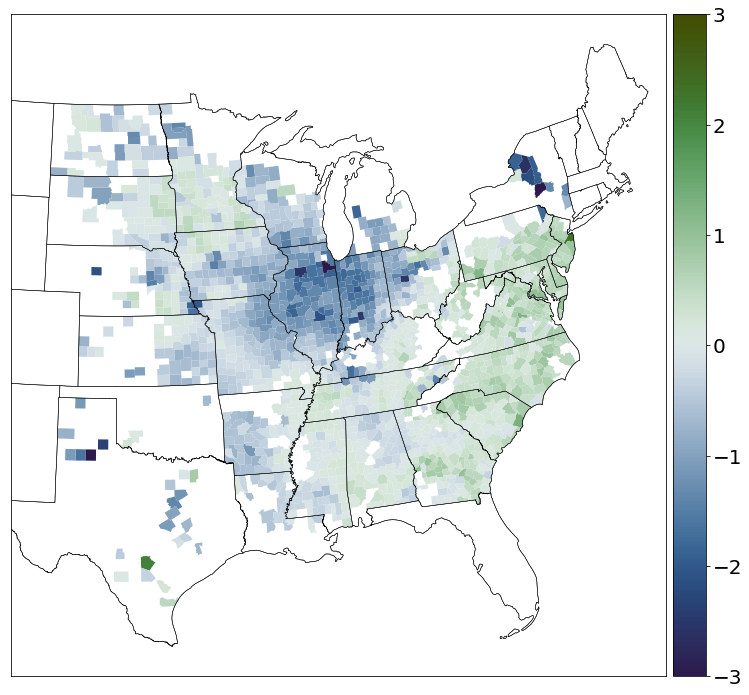

In [170]:
# Plot
model = 'gmfd_min'
vmin = -3.
vmax = 3.

data = ratio.copy()
data.set_index('GEOID', inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.tick_params(labelsize=20)
data_shp = pd.merge(county_shp_plot, data.filter([model, 'GEOID']), on="GEOID", how="inner", copy=False)
data_shp.dropna().plot(column=model, ax=ax, cax=cax, legend=True, cmap=cork_map, vmin=vmin, vmax=vmax)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-500000,2600000])
plt.tight_layout()
plt.show()

# Previous results...

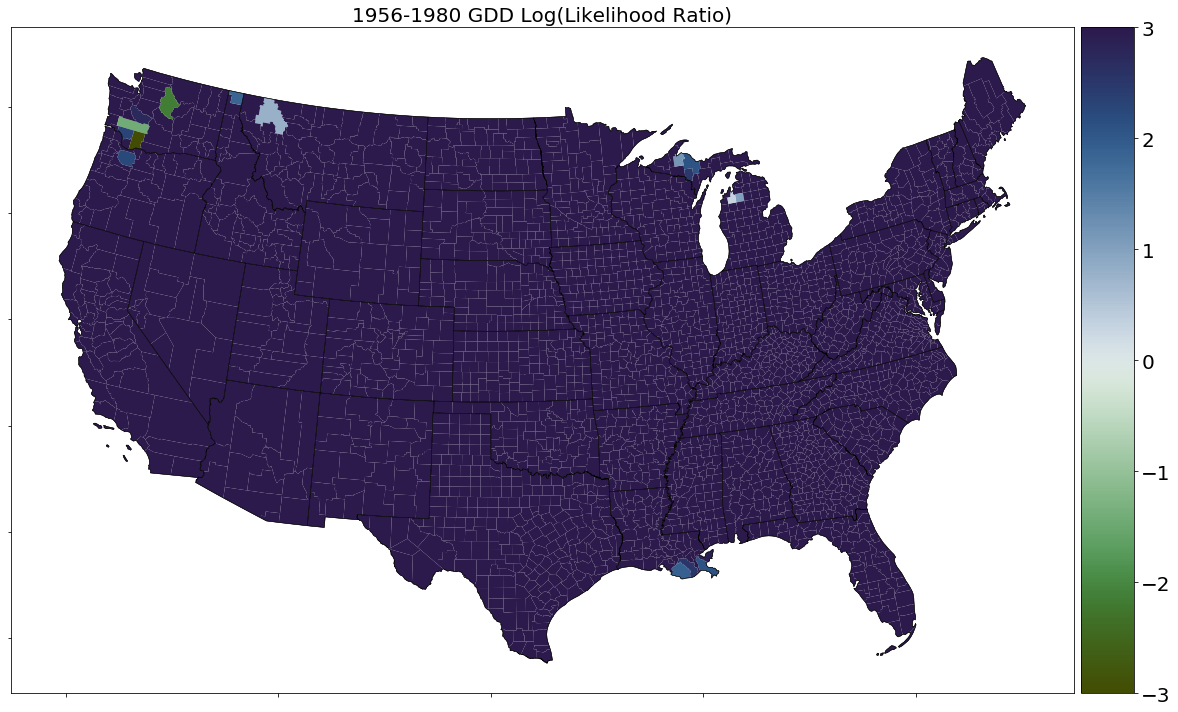

In [75]:
PlotAgVar(res, 'logratio', 'gdd', '1956-1980 GDD Log(Likelihood Ratio)', -3., 3., 'cork')

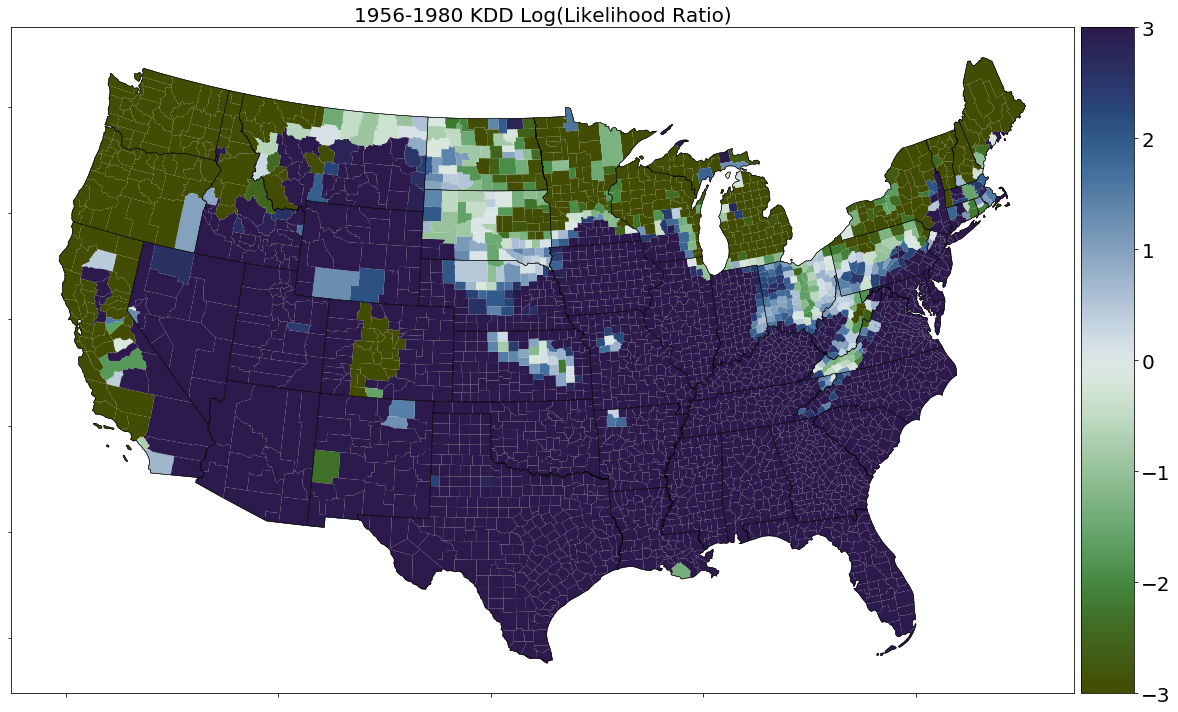

In [76]:
PlotAgVar(res, 'logratio', 'egdd', '1956-1980 KDD Log(Likelihood Ratio)', -3., 3., 'cork')

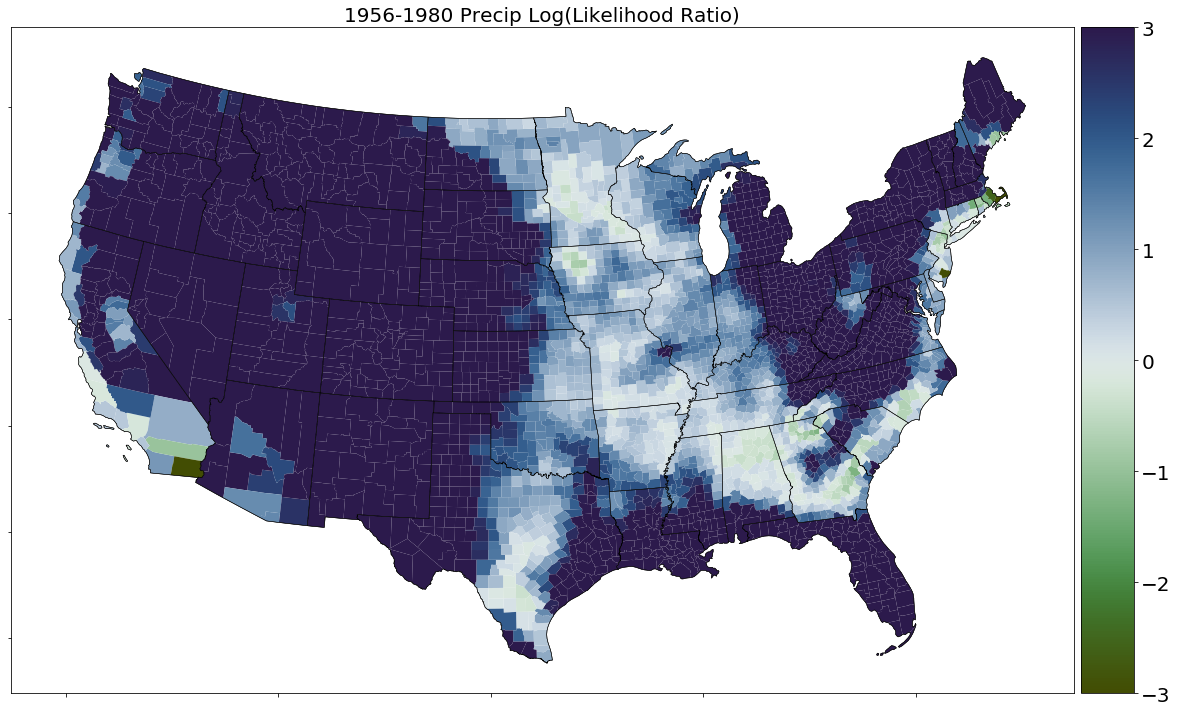

In [77]:
PlotAgVar(res, 'logratio', 'prcp', '1956-1980 Precip Log(Likelihood Ratio)', -3., 3., 'cork')

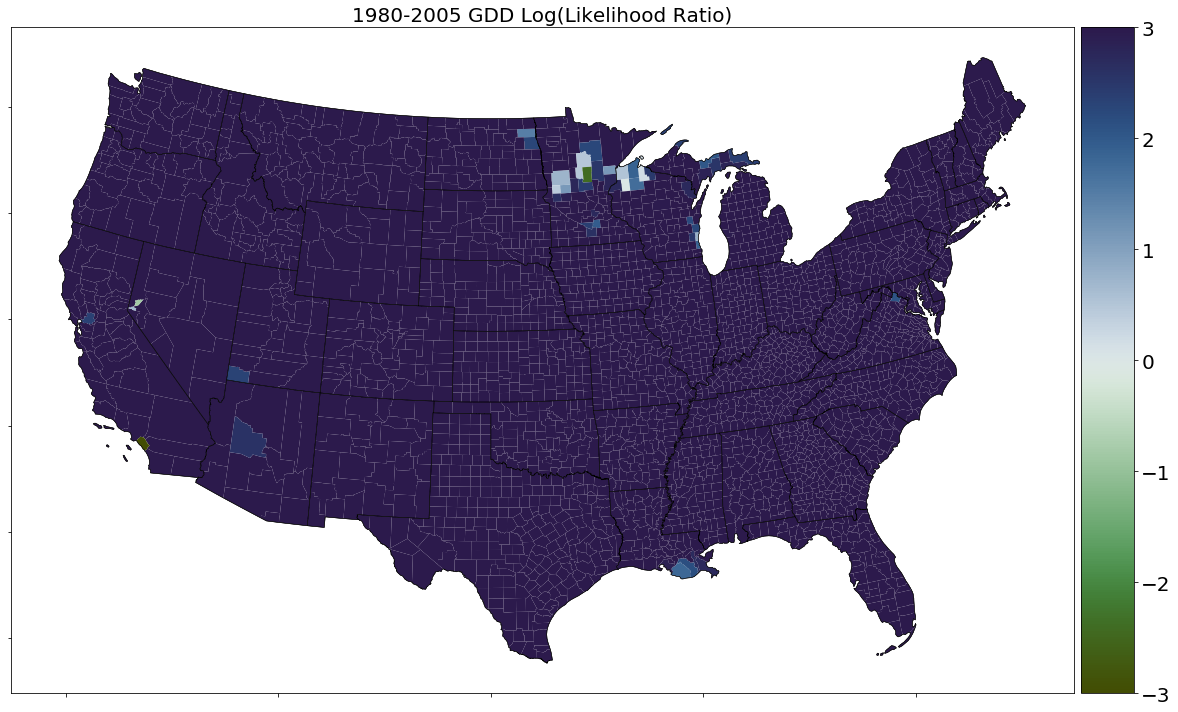

In [63]:
PlotAgVar(res, 'logratio', 'gdd', '1980-2005 GDD Log(Likelihood Ratio)', -3., 3., 'cork')

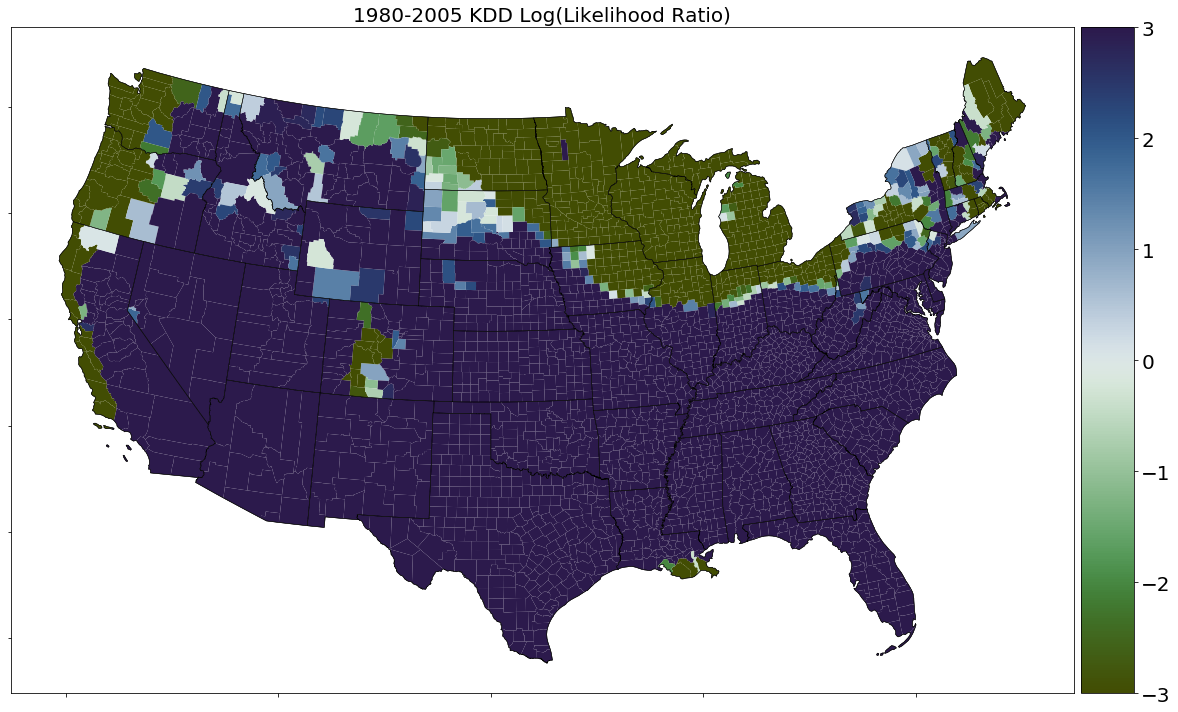

In [60]:
PlotAgVar(res, 'logratio', 'egdd', '1980-2005 KDD Log(Likelihood Ratio)', -3., 3., 'cork')

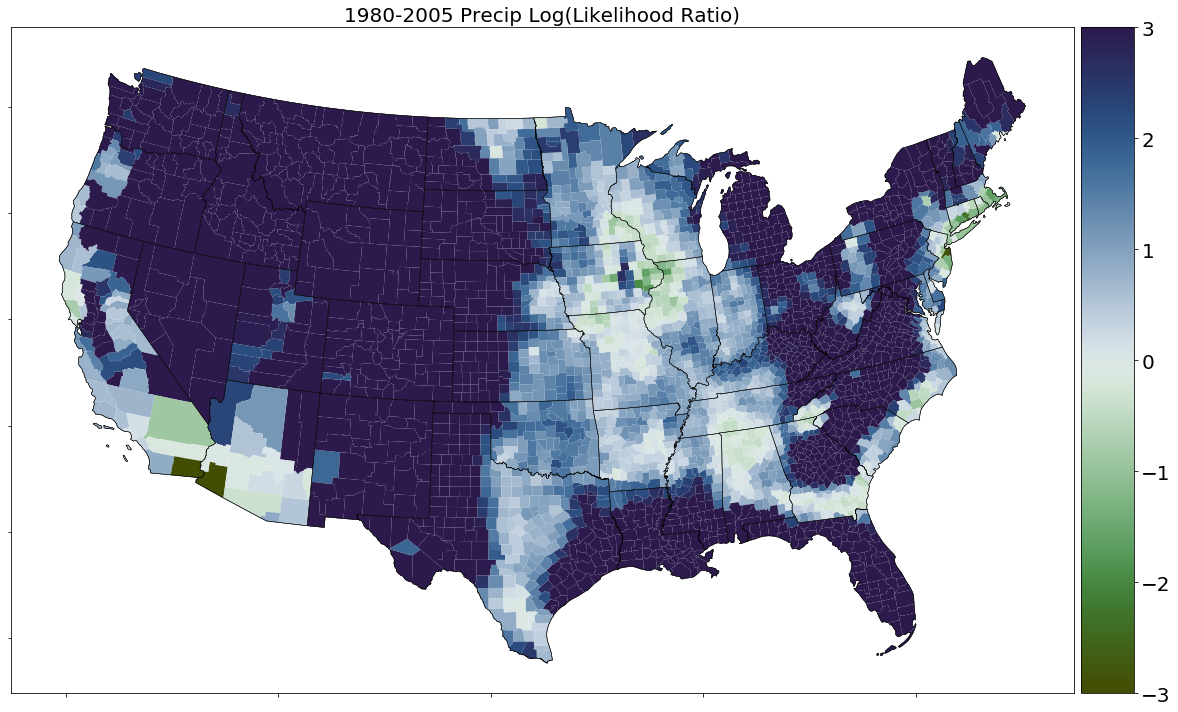

In [61]:
PlotAgVar(res, 'logratio', 'prcp', '1980-2005 Precip Log(Likelihood Ratio)', -3., 3., 'cork')